<a href="https://colab.research.google.com/github/TripopN/Walmart-stock-price-movement-prediction-with-logistic-regression/blob/main/6610422011_Assignment_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary lib

In [30]:
pip install TA-Lib

  Using cached TA-Lib-0.4.28.tar.gz (357 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: Could not build wheels for TA-Lib, which is required to install pyproject.toml-based projects


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Get **Walmart** stock price from yahoo finance.

In [160]:
wmt = yf.Ticker('wmt')
interval = '1h'
start = '2023-1-1'
end = '2023-12-31'
df = wmt.history(interval=interval,start=start,end=end)

In [245]:
wmt_df =df.copy()

In [246]:
wmt_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1742 entries, 2023-01-03 09:30:00-05:00 to 2023-12-29 15:30:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1742 non-null   float64
 1   High          1742 non-null   float64
 2   Low           1742 non-null   float64
 3   Close         1742 non-null   float64
 4   Volume        1742 non-null   int64  
 5   Dividends     1742 non-null   float64
 6   Stock Splits  1742 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 108.9 KB


In [169]:
wmt_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

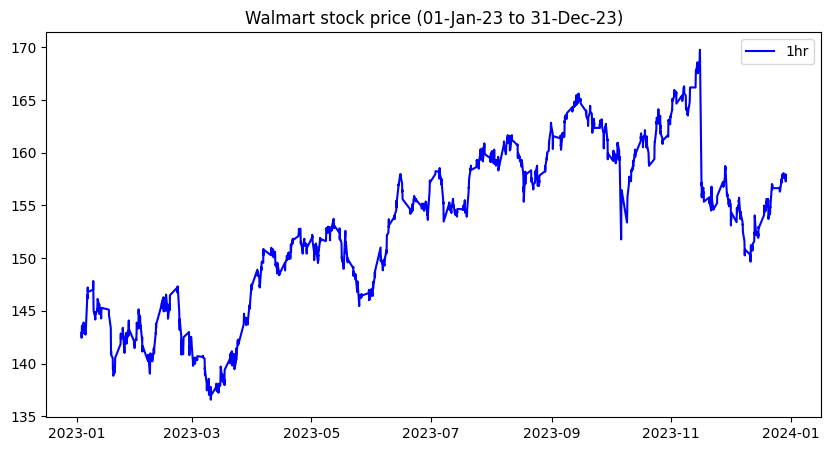

In [140]:
plt.figure(figsize = (10,5))
plt.plot(wmt_df['Close'], color ='b', label = '1hr')
plt.title("Walmart stock price (01-Jan-23 to 31-Dec-23)")
plt.legend()
plt.show()

 Define Predictor/Independent Variables

In [247]:
wmt_df['ema_5'] = wmt_df['Close'].ewm(span=5, adjust=False, min_periods=5).mean()
wmt_df['ema_15'] = wmt_df['Close'].ewm(span=15, adjust=False, min_periods=5).mean()
#wmt_df['S_10'] = wmt_df['Close'].rolling(window=10).mean()
#wmt_df['S_50'] = wmt_df['Close'].rolling(window=50).mean()
wmt_df["ema_5-ema_15"] = wmt_df['ema_5'] - wmt_df['ema_15']
wmt_df['Open-Close'] = wmt_df['Open'] - wmt_df['Close'].shift(1)
wmt_df['Open-Open'] = wmt_df['Open'] - wmt_df['Open'].shift(1)
wmt_df = wmt_df.dropna()


In [248]:
wmt_df = wmt_df.drop(columns = ['Dividends','Stock Splits'])
wmt_df.head()

,Open,High,Low,Close,Volume,ema_5,ema_15,ema_5-ema_15,Open-Close,Open-Open
Datetime,,,,,,,,,,
2023-01-03 13:30:00-05:00,142.669998,143.070007,142.589996,142.949997,479814,142.782097,142.822506,-0.040409,-0.020004,0.229996
2023-01-03 14:30:00-05:00,142.949997,143.580002,142.809998,143.490005,698456,143.018067,142.905943,0.112123,0.000000,0.279999
2023-01-03 15:30:00-05:00,143.500000,143.710007,143.440002,143.580002,935235,143.205378,142.990201,0.215178,0.009995,0.550003
2023-01-04 09:30:00-05:00,143.419998,143.750000,142.070007,143.100006,821172,143.170254,143.003926,0.166328,-0.160004,-0.080002
2023-01-04 10:30:00-05:00,143.089996,143.279999,142.710098,143.250000,495783,143.196836,143.034686,0.162151,-0.010010,-0.330002


In [249]:
X = wmt_df.iloc[:,:10]

In [250]:
X.tail()

,Open,High,Low,Close,Volume,ema_5,ema_15,ema_5-ema_15,Open-Close,Open-Open
Datetime,,,,,,,,,,
2023-12-29 11:30:00-05:00,157.750595,157.820007,157.160004,157.274994,468988,157.612056,157.546298,0.065758,-0.009399,-0.219406
2023-12-29 12:30:00-05:00,157.270004,157.690002,157.240005,157.574997,457363,157.599703,157.549886,0.049818,-0.004990,-0.480591
2023-12-29 13:30:00-05:00,157.580002,157.809998,157.559998,157.660004,533250,157.619803,157.563650,0.056153,0.005005,0.309998
2023-12-29 14:30:00-05:00,157.669998,157.929993,157.639999,157.889999,803502,157.709869,157.604444,0.105425,0.009995,0.089996
2023-12-29 15:30:00-05:00,157.899994,158.020004,157.649994,157.649994,1579816,157.689910,157.610138,0.079773,0.009995,0.229996


Define Target/Dependent Variable

In [251]:
y = np.where(wmt_df['Close'].shift(-1) > wmt_df['Close'],1,-1)

In [252]:
y

array([ 1,  1, -1, ...,  1, -1, -1])

Split The Dataset

In [253]:
split = int(0.7*len(wmt_df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [254]:
X_train.shape


(1216, 10)

Instantiate The Logistic Regression in Python

In [255]:
logis = LogisticRegression()
logis = logis.fit(X_train,y_train)

Examine The Coefficients

In [256]:
pd.DataFrame(zip(X.columns, np.transpose(logis.coef_)))

,0,1
0,Open,[0.0002948779304848202]
1,High,[0.00029527879099758216]
2,Low,[0.0002933116654589178]
3,Close,[0.00029481935351831665]
4,Volume,[-1.988199907653472e-07]
5,ema_5,[0.00029484657842252193]
6,ema_15,[0.0002942933950676949]
7,ema_5-ema_15,[5.531833548267845e-07]
8,Open-Close,[5.175651593954503e-08]
9,Open-Open,[-6.062637617159437e-08]


Calculate Class Probabilities

In [257]:
# Specify the date for prediction
prediction_date = '2023-09-20'
probability = logis.predict_proba(X_test)
print(probability)

[[0.4672626  0.5327374 ]
 [0.45641413 0.54358587]
 [0.45277228 0.54722772]
 ...
 [0.45696051 0.54303949]
 [0.47027375 0.52972625]
 [0.50881884 0.49118116]]


In [258]:
print(X_test.tail())


                                 Open        High         Low       Close  \
Datetime                                                                    
2023-12-29 11:30:00-05:00  157.750595  157.820007  157.160004  157.274994   
2023-12-29 12:30:00-05:00  157.270004  157.690002  157.240005  157.574997   
2023-12-29 13:30:00-05:00  157.580002  157.809998  157.559998  157.660004   
2023-12-29 14:30:00-05:00  157.669998  157.929993  157.639999  157.889999   
2023-12-29 15:30:00-05:00  157.899994  158.020004  157.649994  157.649994   

                            Volume       ema_5      ema_15  ema_5-ema_15  \
Datetime                                                                   
2023-12-29 11:30:00-05:00   468988  157.612056  157.546298      0.065758   
2023-12-29 12:30:00-05:00   457363  157.599703  157.549886      0.049818   
2023-12-29 13:30:00-05:00   533250  157.619803  157.563650      0.056153   
2023-12-29 14:30:00-05:00   803502  157.709869  157.604444      0.105425   
2023

Predict Class Labels

In [259]:
predicted = logis.predict(X_test)

In [260]:
print(predicted)
print(len(predicted))

[ 1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1
  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1

Evaluate The Model

In [261]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 29 214]
 [ 31 248]]


In [262]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.48      0.12      0.19       243
           1       0.54      0.89      0.67       279

    accuracy                           0.53       522
   macro avg       0.51      0.50      0.43       522
weighted avg       0.51      0.53      0.45       522



Create Trading Strategy Using The Model

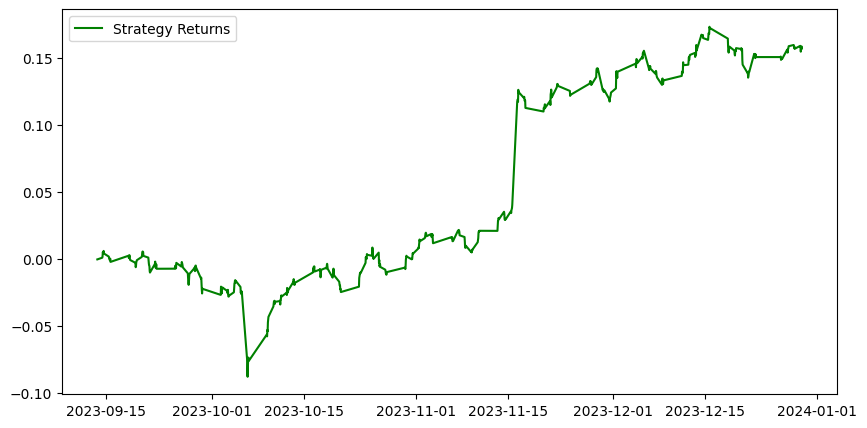

In [263]:
wmt_df['Predicted_Signal'] = logis.predict(X)
wmt_df['WMT_returns'] = np.log(wmt_df['Close']/wmt_df['Close'].shift(1))
Cumulative_WMT_returns = np.cumsum(wmt_df[split:]['WMT_returns'])


wmt_df['Strategy_returns'] = wmt_df['WMT_returns']* wmt_df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(wmt_df[split:]['Strategy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()